In [1]:
import os
import cv2
import numpy as np
import zipfile
import matplotlib.pyplot as plt

In [2]:
def unzip_folder(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted files to: {extract_to}")

In [3]:
unzip_folder("/content/archive.zip","/content/")

Extracted files to: /content/


In [4]:
import os
import shutil

# Paths to the main directories
normal_dir = '/content/Data/NORMAL'
hemorrhagic_dir = '/content/Data/Hemorrhagic'

# Move images from subfolders in NORMAL
for root, dirs, files in os.walk(normal_dir):
    for file in files:
        file_path = os.path.join(root, file)
        # Move file to the main NORMAL directory if it’s not already there
        # Check if the file exists in the destination before moving
        destination_path = os.path.join(normal_dir, file)
        if file_path != destination_path and not os.path.exists(destination_path):
            shutil.move(file_path, normal_dir)

# Move images from subfolders in Hemorrhagic
for root, dirs, files in os.walk(hemorrhagic_dir):
    for file in files:
        file_path = os.path.join(root, file)
        # Move file to the main Hemorrhagic directory if it’s not already there
        # Check if the file exists in the destination before moving
        destination_path = os.path.join(hemorrhagic_dir, file)
        if file_path != destination_path and not os.path.exists(destination_path):
            shutil.move(file_path, hemorrhagic_dir)

# Now you can remove empty subfolders if desired
for root, dirs, files in os.walk(normal_dir):
    for dir in dirs:
        shutil.rmtree(os.path.join(root, dir))

for root, dirs, files in os.walk(hemorrhagic_dir):
    for dir in dirs:
        shutil.rmtree(os.path.join(root, dir))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

normal_images = len(os.listdir('/content/Data/NORMAL'))
hemorrhagic_images = len(os.listdir('/content/Data/Hemorrhagic'))

print(f"Normal images: {normal_images}, Hemorrhagic images: {hemorrhagic_images}")

# Create the ImageDataGenerator with validation split and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale image pixel values to [0, 1]
    validation_split=0.3,       # Validation split
    width_shift_range=0.2,      # Shift images horizontally by 20%
    height_shift_range=0.2,     # Shift images vertically by 20%
    rotation_range=40,          # Rotate images randomly up to 40 degrees
    zoom_range=0.2,             # Zoom in/out on images by 20%
    shear_range=0.2,            # Shear transformation up to 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill missing pixels after transformation
)

# Create the training generator (70% of data)
train_generator = datagen.flow_from_directory(
    '/content/Data',              # Path to your dataset folder
    target_size=(128, 128),   # Resize images to this size
    batch_size=32,
    class_mode='binary',    # Use 'binary' or 'categorical' depending on your problem
    subset='training',      # Use the 'training' subset (70% of data)
    shuffle=True            # Shuffle training data
)

# Create the validation generator (30% of data)
validation_generator = datagen.flow_from_directory(
    '/content/Data',              # Path to your dataset folder
    target_size=(128, 128),   # Resize images to this size
    batch_size=32,
    class_mode='binary',    # Use 'binary' or 'categorical' depending on your problem
    subset='validation',    # Use the 'validation' subset (30% of data)
    shuffle=False           # Do not shuffle validation data
)


Normal images: 4105, Hemorrhagic images: 2689
Found 4757 images belonging to 2 classes.
Found 2037 images belonging to 2 classes.


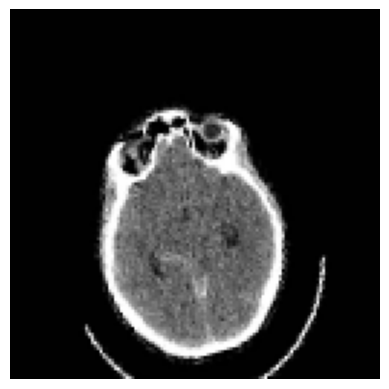

In [6]:
# Get one batch of images and labels from the training generator
images, labels = next(train_generator)

# Get the first image from the batch
image = images[0]

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [7]:
# Logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Each image is currently in 3D (height x width x channels)
# For logistic regression, each image should be reshaped to a 1D array

# Collect all training data in batches from train_generator
train_images, train_labels = [], []
# train_generator loads in batches, so for loop until all images are processed
for _ in range(train_generator.samples // train_generator.batch_size + 1):
    images, labels = next(train_generator)
    train_images.append(images)
    train_labels.append(labels)
train_images = np.vstack(train_images)  # Stacks all batches into a single array
train_labels = np.concatenate(train_labels)  # Combines all label batches into one 1D array
train_images = train_images.reshape(train_images.shape[0], -1)  # Flatten each image to a 1D array
# Each image is 128x128 pixels with 3 color channels, so each 1D array will have 128 x 128 x 3 = 49,152 features.

# Do the same for the validation data
# Get all validation data in batches from validation_generator
validation_images, validation_labels = [], []
for _ in range(validation_generator.samples // validation_generator.batch_size + 1):
    images, labels = next(validation_generator)
    validation_images.append(images)
    validation_labels.append(labels)
validation_images = np.vstack(validation_images) # Collects images
validation_labels = np.concatenate(validation_labels) # Collects labels
validation_images = validation_images.reshape(validation_images.shape[0], -1) # validation_images is reshaped to a 2D array with each image as a 1D array

In [8]:
# Train the logistic regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(train_images, train_labels) # Fit logistic regression model using the training data (flattened images) and labels

LogisticRegression(max_iter=1000)

In [9]:
# Predict the validation images using the trained logistic model
validation_preds = log_model.predict(validation_images)
accuracy = accuracy_score(validation_labels, validation_preds)
class_report = classification_report(validation_labels, validation_preds, target_names=['Normal', 'Hemorrhagic'])

# Print the accuracy and report

print("Logistic Regression Evaluation")
print("Validation Accuracy: ", accuracy)
print("Classification Report:")
print(class_report)

Logistic Regression Evaluation
Validation Accuracy:  0.5208640157093766
Classification Report:
              precision    recall  f1-score   support

      Normal       0.39      0.38      0.39       806
 Hemorrhagic       0.60      0.61      0.61      1231

    accuracy                           0.52      2037
   macro avg       0.50      0.50      0.50      2037
weighted avg       0.52      0.52      0.52      2037



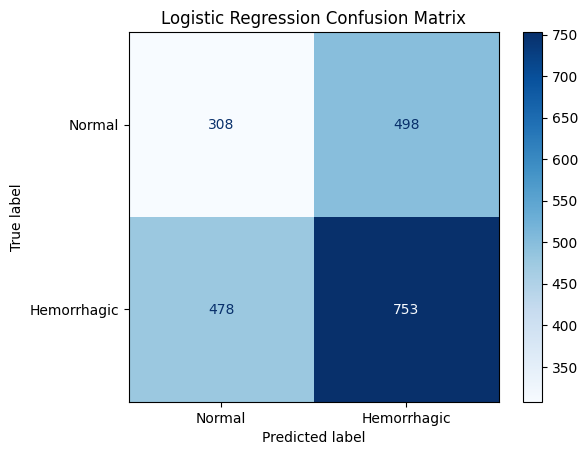

In [13]:
# Visualization

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(validation_labels, validation_preds)

# Display it as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Hemorrhagic'])
disp.plot(cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

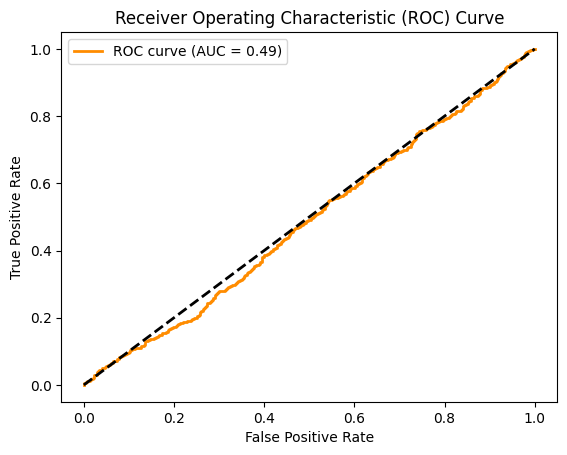

In [11]:
# Roc curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC (Area Under Curve)
false_positive_rate, true_positive_rate, _ = roc_curve(validation_labels, log_model.predict_proba(validation_images)[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

# Plot ROC curve
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="upper left")
plt.show()

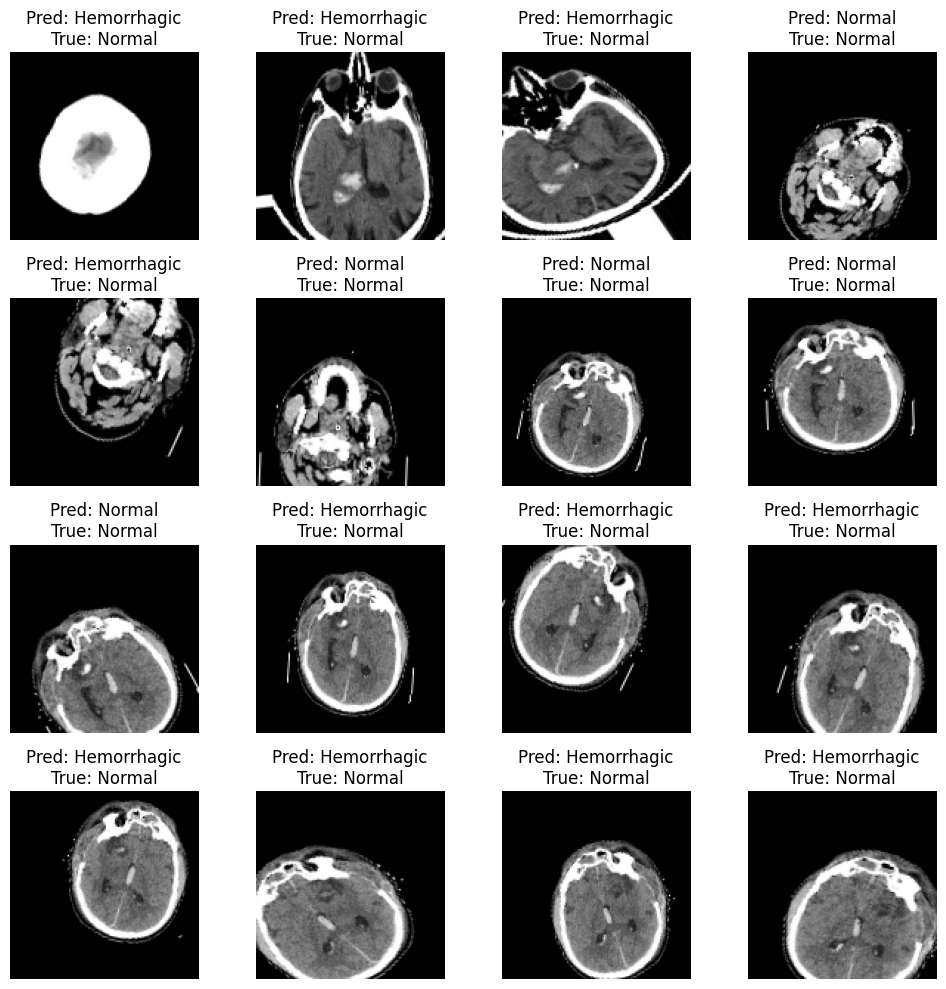

In [12]:
# Sample Predictions Visualization
# Select some sample images and labels from the validation set
sample_images = validation_images[:16].reshape(-1, 128, 128, 3)  # Reshape back to 128x128x3
sample_labels = validation_labels[:16]
sample_preds = validation_preds[:16]

# Plot these images with predicted and true labels
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    plt.title(f'Pred: {"Hemorrhagic" if sample_preds[i] == 1 else "Normal"}\nTrue: {"Hemorrhagic" if sample_labels[i] == 1 else "Normal"}')
plt.tight_layout()
plt.show()